In [12]:

import numpy as np
from scipy.signal import correlate, correlation_lags
import matplotlib.pyplot as plt
def autocorr_scipy(E):
    """
    Calcula la autocorrelación normalizada usando
    scipy.signal.correlate con método FFT.
    """
    E = np.asarray(E, dtype=float)
    E_centered = E - E.mean()
    N = len(E)
    corr_full = correlate(E_centered, E_centered, mode='full', method='fft')
    lags = correlation_lags(N, N, mode='full')
    mask = lags >= 0
    corr = corr_full[mask] / corr_full[mask][0]  # normaliza
    lags = lags[mask]
    return lags, corr


def tau_by_threshold(lags, C, level=np.exp(-1)):
    """Devuelve tau tal que C(tau)=e^-1 (interp. lineal).
       lags y C son 1D, con lags[0]=0 y C[0]≈1."""
    lags = np.asarray(lags, float)
    C = np.asarray(C, float)

    # Asegura normalización (por si acaso)
    if C[0] != 0:
        C = C / C[0]

    # Busca primer índice donde C cruza por debajo de e^-1
    below = np.where(C <= level)[0]
    if len(below) == 0:
        return np.nan  # nunca cruza (corr. muy larga o datos cortos)

    i = below[0]
    if i == 0:  # caso degenerado
        return 0.0

    # Interpolación lineal entre (i-1) y i
    x0, y0 = lags[i-1], C[i-1]
    x1, y1 = lags[i],   C[i]
    if y1 == y0:
        return x1  # evita división por cero; mejor aproximación disponible
    tau = x0 + (level - y0) * (x1 - x0) / (y1 - y0)
    return tau


In [25]:
381*1000

381000

bloques: 124166, B=12, muestras ~independientes: 124166


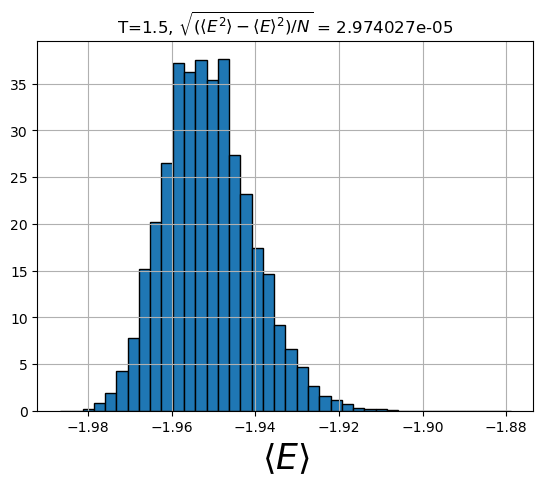

In [88]:
import numpy as np
import matplotlib.pyplot as plt

T = 1.5
fname = f"E_thermalize_{T:.2f}.dat"
results = np.loadtxt(fname)

step = results[:, 0]
E    = results[:, 1]

# 1) Burn-in
burn = 10000
E_eq = E[step >= burn]

# 2) Tau y tamaño de bloque
lags, C = autocorr_scipy(E_eq)
tau = 2 * tau_by_threshold(lags, C, level=np.exp(-1))

# si tau sale 0 o NaN, poné un mínimo para no romper
if not np.isfinite(tau) or tau <= 0:
    tau = 1.0

k = 4
B = k * tau                       # puede ser float
B_int = max(1, int(round(B)))     # <-- AQUI: entero y al menos 1

# 3) Bloques completos y reshape
N = len(E_eq)
nblocks = N // B_int              # entero (//)
if nblocks < 1:
    raise ValueError(f"B={B_int} es muy grande para N={N}. Bajá k o aumentá datos.")

E_trim = E_eq[: nblocks * B_int]  # recorte exacto a múltiplo de B
E_blocks = E_trim.reshape(nblocks, B_int).mean(axis=1)

print(f"bloques: {nblocks}, B={B_int}, muestras ~independientes: {nblocks}")

# 4) Histograma de medias de bloque
plt.hist(E_blocks, bins=40, edgecolor='k', density=True)
plt.xlabel(r'$\langle E\rangle$', fontsize=25)
errE = np.sqrt((np.mean(E_blocks**2) - np.mean(E_blocks)**2) / len(E_blocks))
plt.title(rf'T={T}, $\sqrt{{(\langle E^2 \rangle - \langle E \rangle^2)/N}}$ = {errE:.7g}')
plt.grid(True)
plt.savefig(f"/home/anibal-pc/histE_lowT.png", dpi=200, bbox_inches='tight')
plt.show()


Text(0.5, 0, '$\\langle E \\rangle$')

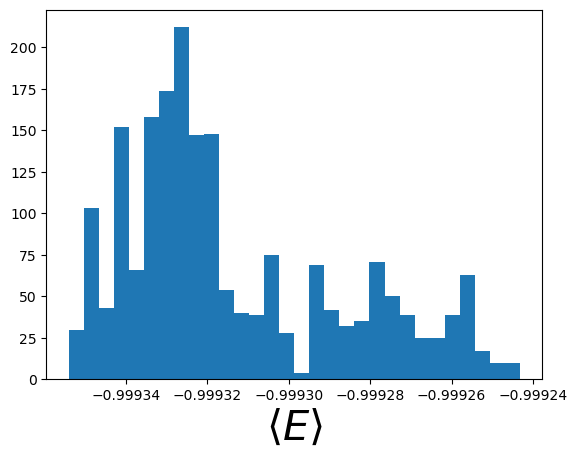

In [32]:
plt.hist(E_mean, bins=30)
plt.xlabel(r"$\langle E \rangle$", fontsize=30)

2.2356098713551327
τ_int estimado ≈ 381.0 pasos


array([-5.83154891e-04, -1.17379191e-03, -2.93492338e-04, ...,
       -6.35844083e-07, -8.37843218e-07, -4.18921609e-07])

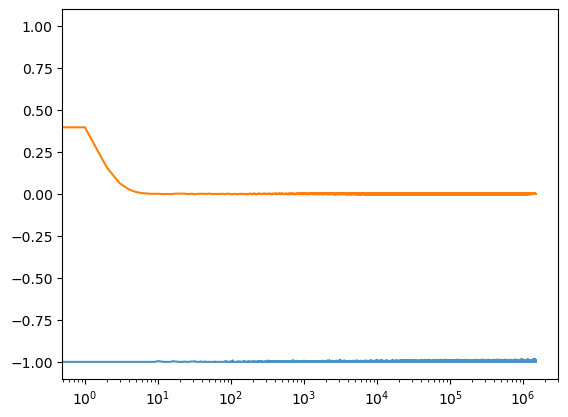

In [22]:

plt.plot(step, E, alpha=0.8)
plt.xscale('log')

# tau_int: sumar autocorrelación hasta que cruza 0
mask = (lags > 0) & (C > 0)
tau_int = 0.5 + np.sum(C[mask])
print(f"τ_int estimado ≈ {tau_int:.1f} pasos")

plt.plot(lags,C)
plt.suptitle()
C_mask = C[C<C*1e-1]
C_mask

/tmp/ipykernel_45099/2978641806.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.12)   # podés ajustar este valor según necesidad


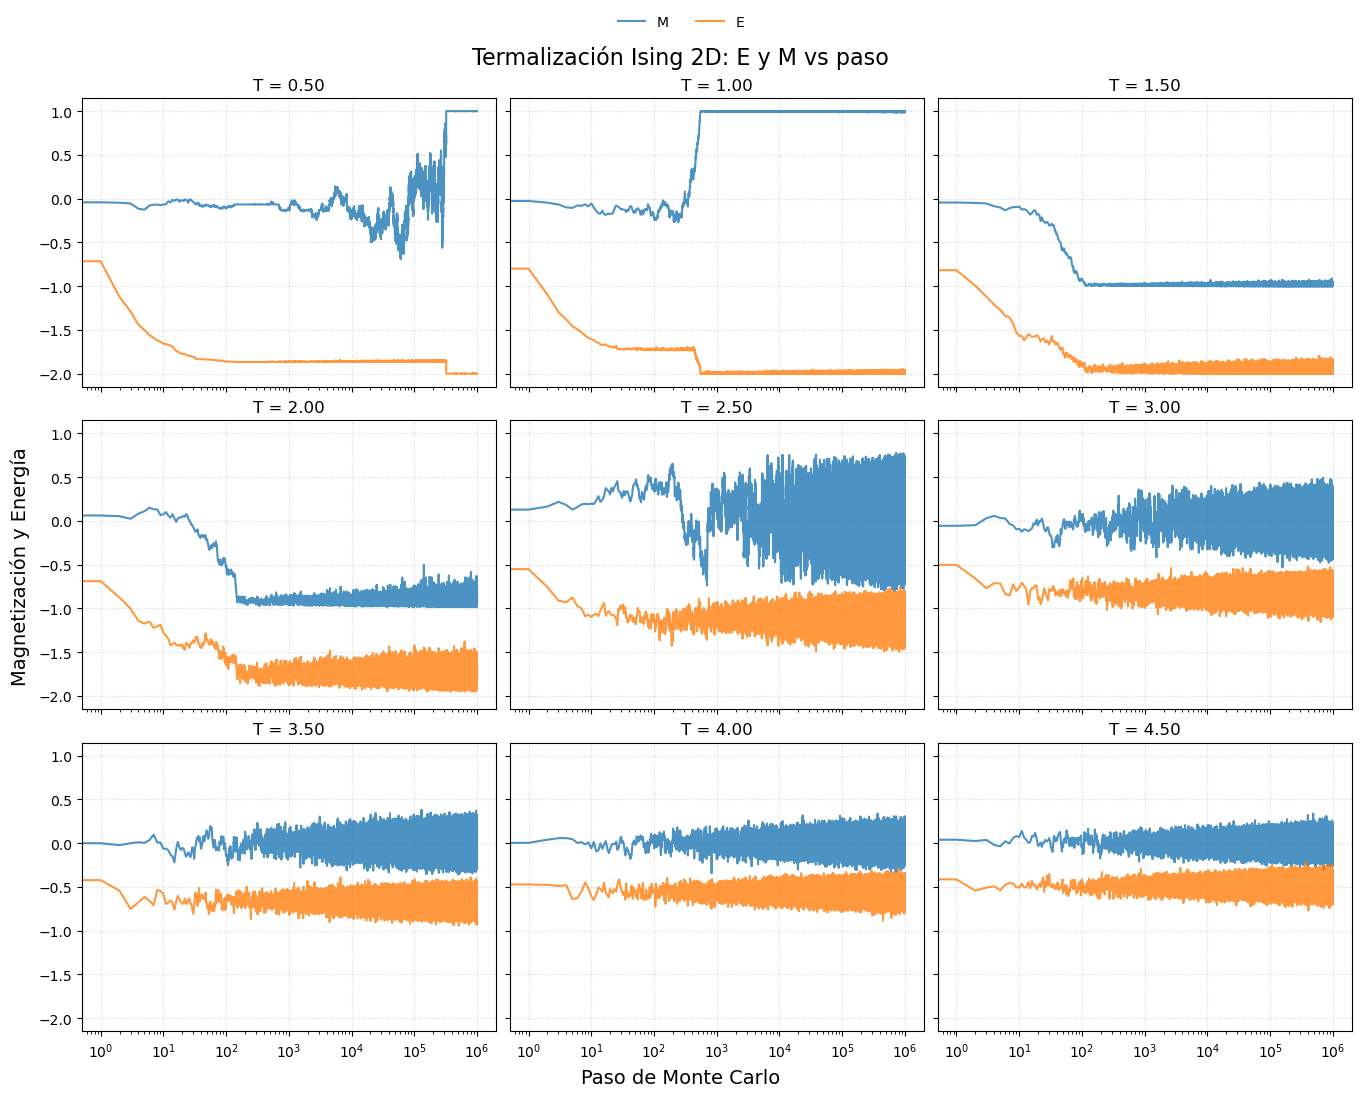

In [49]:
import numpy as np
import matplotlib.pyplot as plt

Ts = np.arange(0.5, 5.0, 0.5)
n = len(Ts)
ncols = 3
nrows = int(np.ceil(n / ncols))

# Usar layout='constrained' (Matplotlib >=3.6). Alternativa: constrained_layout=True.
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(4.5*ncols, 3.5*nrows),
    sharex=True, sharey=True,
    layout='constrained'
)
axes = np.atleast_2d(axes).reshape(nrows, ncols)

for idx, T in enumerate(Ts):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    fname = f"M_thermalize_{T:.2f}.dat"
    fname2 = f"E_thermalize_{T:.2f}.dat"
    try:
        step, M = np.loadtxt(fname, unpack=True)
        ax.plot(step, M, alpha=0.8, label='M')

        step2, E = np.loadtxt(fname2, unpack=True)
        ax.plot(step2, E, alpha=0.8, label='E')

        ax.set_xscale("log")
        ax.set_title(f"T = {T:.2f}")
        ax.grid(True, ls=":", alpha=0.5)
    except OSError:
        ax.set_title(f"{fname} no encontrado")
        ax.axis("off")

# Ocultar celdas vacías
for j in range(n, nrows*ncols):
    r, c = divmod(j, ncols)
    axes[r, c].axis("off")

# Solo etiquetas de X en la última fila
# for c in range(ncols):
#     axes[-1, c].set_xlabel("Paso de Monte Carlo")

# --- Etiquetas y título globales (constrained_layout las acomoda sin solapar) ---
fig.suptitle("Termalización Ising 2D: E y M vs paso", fontsize=16)
fig.supylabel("Magnetización y Energía", fontsize=14)
fig.supxlabel("Paso de Monte Carlo", fontsize=14)

# Leyenda global centrada abajo
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1),  # un poco más abajo del borde de la figura
    bbox_transform=fig.transFigure
)

# Ajustar márgenes para que no se superpongan con la leyenda
fig.subplots_adjust(bottom=0.12)   # podés ajustar este valor según necesidad
plt.savefig('/home/anibal-pc/EMvsstep.png')
plt.show()


In [9]:
Tmin   = 1.55
Tmax   = 3.05
dT     = 0.1
nsteps = int( (Tmax - Tmin)/dT ) 
nsteps

14

/tmp/ipykernel_44843/3732759028.py:10: RuntimeWarning: divide by zero encountered in divide
  chi1 = 1/(2*(T_c - T1))
/tmp/ipykernel_44843/3732759028.py:11: RuntimeWarning: divide by zero encountered in divide
  chi2 = 1/(T2-T_c)
/tmp/ipykernel_44843/3732759028.py:35: RuntimeWarning: divide by zero encountered in divide
  l2=1/(1-L2)


Text(0.5, 0.98, 'Campo medio')

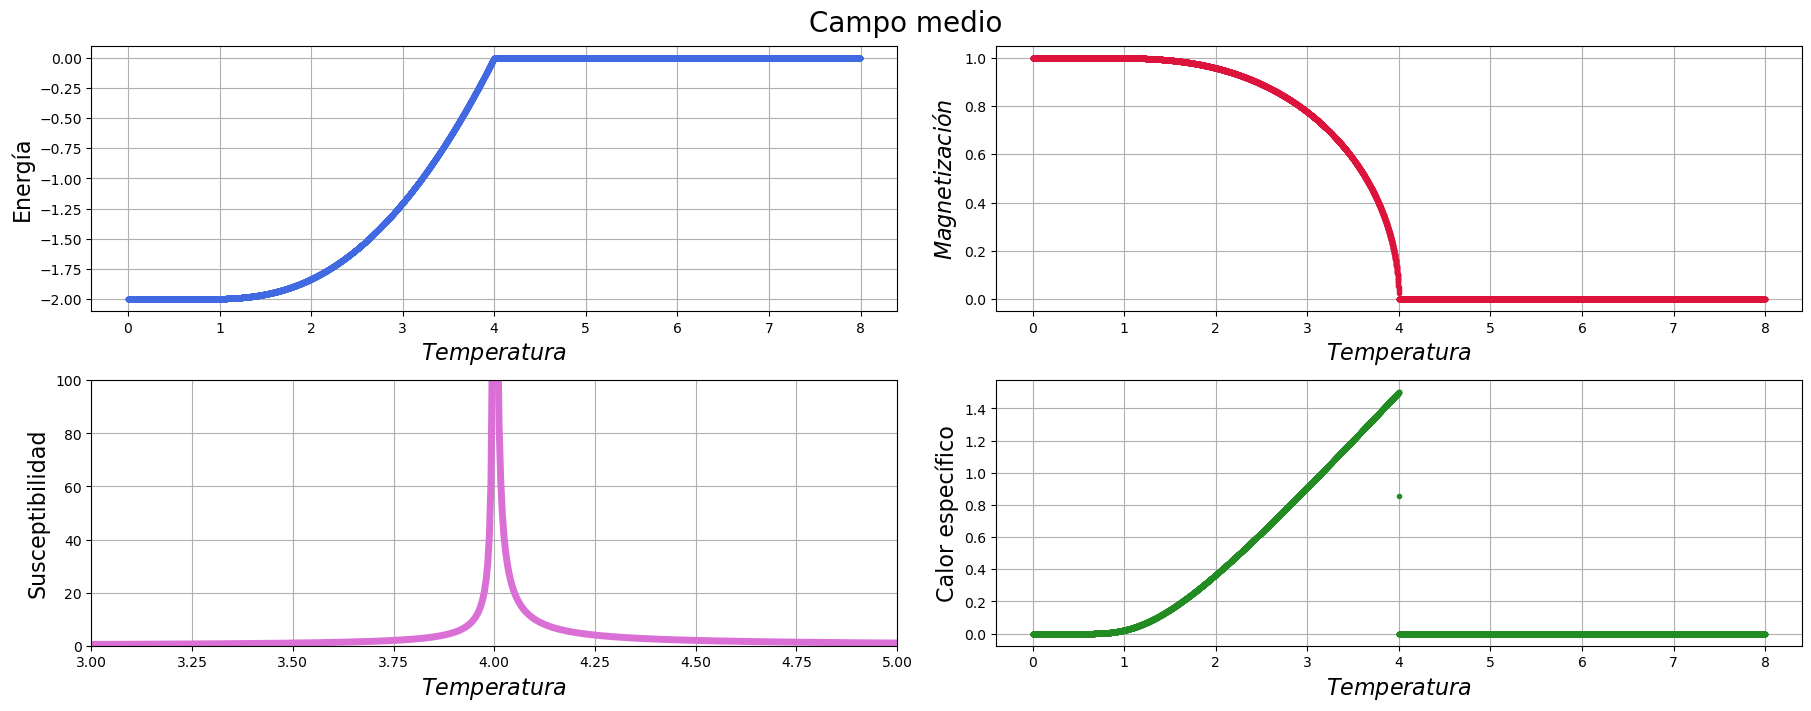

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
#--------------------------------------------------------------------
#Graficamos la suceptibilidad
T_c = 4    #para una red de Ising 2D Tc=4*J/Kb
cero=10**(-8)
T1=np.linspace(cero,T_c,1000)
T2=np.linspace(T_c,8,1000)
chi1 = 1/(2*(T_c - T1))
chi2 = 1/(T2-T_c)

#--------------------------------------------------------------------
#resuelve la ecuacion de autoconsistencia usando el metodo de Newton
# Definimos la función a la que le queremos buscar los ceros
def f(x):
    return x - np.tanh(beta*q*J*x)

    # Definimos parámetros para el sistema
q   = 4   # Número de primeros vecinos
J   = 1   # Energía de interacción entre primeros vecinos
kTc = q*J # Temperatura crítica
# Calculamos los ceros de la función entre kT=0 y kT=2*kTc. Generamos un vector con temperaturas en este rango.
kT = np.arange(.0001*2*kTc, 2*kTc, .0001*2*kTc)
L0 = np.zeros(np.size(kT))

# Usamos el método de la secante para encontrar los ceros para cada temperatura
x = 1.1 # Guess inicial
for i in range(np.size(kT)):
    beta = 1./kT[i]
    L0[i] = newton(f, x, tol=1e-08, maxiter=100)
#--------------------------------------------------------------------
#Calor especifico
L2=L0**2
l2=1/(1-L2)
tt=kT/kTc
tt2=tt**2
c=L2/((tt2)*(l2)-tt)
#--------------------------------------------------------------------
fig = plt.figure(constrained_layout=True,figsize=(18,7))
gs=fig.add_gridspec(2,2)

ax2=fig.add_subplot(gs[0,0])
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Energía',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(kT,-2*np.abs(L0)**2,color='royalblue',marker='.',linestyle='')

ax1=fig.add_subplot(gs[0,1])
ax1.set_xlabel(r'$Temperatura$',fontsize=16)
ax1.set_ylabel(r'$Magnetización$',fontsize=16)
ax1.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax1.plot(kT,L0,color='crimson',marker='.',linestyle='')

ax2=fig.add_subplot(gs[1,0])
plt.xlim(3,5)
plt.ylim(0,100)
ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Susceptibilidad',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(T2,chi2,color='orchid',marker='',linestyle='-',lw='5')
ax2.plot(T1,chi1,color='orchid',marker='',linestyle='-',lw='5')

ax2=fig.add_subplot(gs[1,1])

ax2.set_xlabel(r'$Temperatura$',fontsize=16)
ax2.set_ylabel(r'Calor específico',fontsize=16)
ax2.grid()
# plt.axvspan(0,4,color='blue', alpha = 0.20)
ax2.plot(kT,c,color='forestgreen',marker='.',linestyle='')

plt.suptitle('Campo medio',fontsize=20)

In [95]:
Tmin   = 1.55
Tmax   = 3.05
dT     = 0.002
nsteps = int( (Tmax - Tmin)/dT ) 
nsteps

749